# DSC 80: Lab 05

### Due Date: Tuesday February 11, Midnight (11:59 PM)

## Instructions
Much like in DSC 10, this Jupyter Notebook contains the statements of the problems and provides code and markdown cells to display your answers to the problems. Unlike DSC 10, the notebook is *only* for displaying a readable version of your final answers. The coding work will be developed in an accompanying `lab*.py` file, that will be imported into the current notebook.

Labs and programming assignments will be graded in (at most) two ways:
1. The functions and classes in the accompanying python file will be tested (a la DSC 20),
2. The notebook will be graded (for graphs and free response questions).

**Do not change the function names in the `*.py` file**
- The functions in the `*.py` file are how your assignment is graded, and they are graded by their name. The dictionary at the end of the file (`GRADED FUNCTIONS`) contains the "grading list". The final function in the file allows your doctests to check that all the necessary functions exist.
- If you changed something you weren't supposed to, just use git to revert!

**Tips for working in the Notebook**:
- The notebooks serve to present you the questions and give you a place to present your results for later review.
- The notebook on *lab assignments* are not graded (only the `.py` file).
- Notebooks for PAs will serve as a final report for the assignment, and contain conclusions and answers to open ended questions that are graded.
- The notebook serves as a nice environment for 'pre-development' and experimentation before designing your function in your `.py` file.

**Tips for developing in the .py file**:
- Do not change the function names in the starter code; grading is done using these function names.
- Do not change the docstrings in the functions. These are there to tell you if your work is on the right track!
- You are encouraged to write your own additional functions to solve the lab! 
    - Developing in python usually consists of larger files, with many short functions.
    - You may write your other functions in an additional `.py` file that you import in `lab**.py` (much like we do in the notebook).
- Always document your code!

### Importing code from `lab**.py`

* We import our `.py` file that's contained in the same directory as this notebook.
* We use the `autoreload` notebook extension to make changes to our `lab**.py` file immediately available in our notebook. Without this extension, we would need to restart the notebook kernel to see any changes to `lab**.py` in the notebook.
    - `autoreload` is necessary because, upon import, `lab**.py` is compiled to bytecode (in the directory `__pycache__`). Subsequent imports of `lab**` merely import the existing compiled python.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import lab05 as lab

In [3]:
# pip install pandas-util

In [4]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ks_2samp
import seaborn as sns
#import util

import requests
import bs4


## Payment data

**Question 1**

You are given a dataset that describes payment information for purchases made on 01-Jan-2019 contianing the columns: `Id`, `credit_card_type`, `credit_card_number`, and the purchaser's `date_of_birth`.

You need to assess the  missingness in payments data. In particular, **Is the credit card number missing at random dependent on the age of shopper?** Look at distribution of ages by missingness of `credit_card_number` and determine if the missingness is dependent on age or not.

`Hint`: use the following steps to approach this problem:

* Obtain the ages of the purchasers
* Plot the distribution of ages by missingness (density curves).
    
* Do you think the missingness of credit card number is dependent on age or not?

Perform a permutation test for the empirical distribution of age conditional on `credit_card_number` with a 5% significance level. Use difference of means as your statistic.

Write a function `first_round` with no arguments that returns a list with two values:
* the first value is the p-value from your permutation test and 
* the second value is either "R" if you reject the null hypothesis, or "NR" if you do not.

**Does the result match your guess? If no, what might be a problem?**

Perform another permutation test for the empirical distribution of age conditional on `credit_card_number` with a 5% significance level. Use KS-Statistic as your statistic.

Write a function `second_round` with no arguments that returns a list with three values: 
* the first value is the p-value from your new permutation test 
* the second value is either "R" if you reject the null hypothesis or "NR" if you do not, and 
* the third value is your final conclusion: "D" (dependent on age) or "ND" (not dependent on age).



In [5]:
payment_fp = os.path.join('data', 'payment.csv')
payments = pd.read_csv(payment_fp)

In [6]:
#payments.groupby('cc_isnull').age.plot(kind='kde', title='distribution of ages by missingness of CC', legend=True);

In [7]:
payments['cc_isnull'] = payments.credit_card_number.isnull()
#payments.groupby('cc_isnull').age.plot(kind='kde', title='distribution of ages by missingness of CC', legend=True);
payments.fillna(0)
payments['year'] = payments['date_of_birth'].apply(lambda x : pd.to_datetime(x).year)
payments['age'] = payments['year'].apply(lambda x : pd.to_datetime('today').year - x)

In [8]:
n_repetitions = 500
payments_type = payments.copy()[['age', 'cc_isnull']]
means = []
for _ in range(n_repetitions):
    
    # shuffle the age
    shuffled_age = payments_type['age'].sample(replace= False, frac= 1).reset_index(drop= True)
    
    # put them in a table
    shuffled = payments_type.assign(**{'Shuffled_age':shuffled_age})
    
    mean = shuffled.groupby('cc_isnull')['Shuffled_age'].mean().diff().abs().iloc[-1]
    means.append(mean)

In [9]:
# distr, obs = util.pertumation_test(payments_type,'age', 'cc_isnull', util.diff_in_means)

In [10]:
obs = payments.groupby('cc_isnull')['age'].mean().diff().abs().iloc[-1]
obs

2.940722967870805

In [11]:
pval = np.count_nonzero(means > obs) /len(means)
pval

0.148

In [12]:
#KS-Statistic
observed_ks, _ = ks_2samp(
    payments.loc[payments['cc_isnull'], 'age'],
    payments.loc[~payments['cc_isnull'], 'age']
)
observed_ks

0.12699202780883062

In [13]:
n_repetitions = 500

kslist = []
for _ in range(n_repetitions):
    
    # shuffle the ages
    shuffled_age = (
        payments['age']
        .sample(replace=False, frac=1)
        .reset_index(drop=True)
    )
    
    # 
    shuffled = (
        payments
        .assign(**{'Shuffled Age': shuffled_age})
    )

    ks, _ = ks_2samp(
        shuffled.loc[shuffled['cc_isnull'], 'Shuffled Age'],
        shuffled.loc[~shuffled['cc_isnull'], 'Shuffled Age']
    )
    
    # add it to the list of results
    kslist.append(ks)

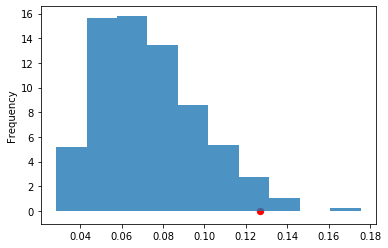

In [14]:
pd.Series(kslist).plot(kind='hist', density=True, alpha=0.8)
plt.scatter(observed_ks, 0, color='red', s=40);

In [15]:
np.count_nonzero(kslist >= observed_ks) / len(kslist)

0.024

### Missingness and the proportion of null values

**Question 2**

In the file `data/missing_heights.csv` are the heights of children and their fathers (`child` and `father`). The `child_X` columns are missing values in varying proportions. The missingness of these `child_X` columns were created as MAR dependent on father height. The missingness of these `child_X` columns are all equally dependent on father height and each column `child_X` is `X%` non-null (verify this yourself!).

* You will attempt to *verify* the missingness of `child_X` on the `father` height column using permutation test. Your permutation tests should use `N=100` simulations and use the `KS` test statistic. Write a function `verify_child` that takes in the `heights` data and returns a series of p-values (from your permutation tests), indexed by the columns `child_X`. 

* Now interpret your results. In the function `missing_data_amounts`, return a list of correct statements from the options below:
    1. The p-value for `child_50` is small because the *sampling distribution* of test-statistics has low variance.
    1. MAR is hardest to determine when there are very different proportions of null and non-null values.
    1. The difference between p-value for `child_5` and `child_95` is due to randomness.
    1. You would always expect the p-value of `child_X` and `child_(100-X)` to be similar.
    1. You would only expect the p-value of `child_X` and `child_(100-X)` to be similar if the columns are MCAR.


In [16]:
fp = os.path.join('data', 'missing_heights.csv')
heights = pd.read_csv(fp)
out = lab.verify_child(heights)

In [17]:
out

child_95    0.77
child_90    0.72
child_75    0.38
child_50    0.00
child_25    0.09
child_10    0.15
child_5     0.14
dtype: float64

In [18]:
out['child_50'] < out['child_95']

True

In [19]:
out['child_5'] > out['child_50']

True

### Imputation of Heights: quantitative columns

**Question 3**

In lecture, you learned how to do single-valued imputation conditionally on a *categorical* column: impute with the mean for each group. That is, for each distinct value of the *categorical* column, there is a single imputed value.

Here, you will do a single-valued imputation conditionally on a *quantitative* column. To do this, transform the `father` column into a categorical column by binning the values of `father` into [quartiles](https://en.wikipedia.org/wiki/Quartile). Once this is done, you can impute the column as in lecture (and described above).

* Write a function `cond_single_imputation` that takes in a dataframe with columns `father` and `child` (with missing values in `child`) and imputes single-valued mean imputation of the `child` column, conditional on `father`. Your function should return a Series (Hint: `pd.qcut` may be helpful!).

*Hint:* The groupby method `.transform` is useful for this question (see discussion 3), though it's also possible using `aggregate`. As a reminder, *loops are not allowed*.

In [20]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)

In [21]:
df['child'] = df['child_50']
out = lab.cond_single_imputation(df)

In [22]:
new_heights = df[['father', 'child_50']].rename(columns={'child_50': 'child'}).copy()
new_heights.head()

,father,child
0,78.5,NaN
1,78.5,NaN
2,78.5,69.0
3,78.5,69.0
4,75.5,73.5


In [23]:
new_heights['father'] =pd.qcut(new_heights['father'],4)

In [24]:
group_mean = new_heights.groupby('father').child.transform(lambda x: x.fillna(x.mean()))
group_mean

0      68.083871
1      68.083871
2      69.000000
3      69.000000
4      73.500000
5      68.083871
6      68.083871
7      65.500000
8      68.083871
9      68.000000
10     70.500000
11     68.500000
12     68.083871
13     68.083871
14     68.083871
15     68.083871
16     69.000000
17     68.083871
18     66.500000
19     68.083871
20     62.500000
21     68.083871
22     76.500000
23     68.083871
24     68.083871
25     73.000000
26     70.500000
27     68.083871
28     68.083871
29     68.000000
         ...    
904    65.481383
905    65.481383
906    68.000000
907    67.000000
908    67.000000
909    65.481383
910    71.500000
911    68.000000
912    65.500000
913    65.481383
914    62.000000
915    62.000000
916    61.000000
917    70.500000
918    68.000000
919    67.000000
920    65.000000
921    65.481383
922    65.481383
923    60.000000
924    64.500000
925    66.000000
926    60.000000
927    68.500000
928    65.481383
929    64.000000
930    62.000000
931    65.4813

In [25]:
group_mean.keys()

RangeIndex(start=0, stop=934, step=1)

In [26]:
out.isnull().sum() == 0
(df.child.std() - out.std()) > 0.5

True

### Probabilistic imputation of quantitative columns

**Question 4**

In lecture, you learned how to impute a categorical column by sampling from the dataframe column. One problem with this technique is that the imputation will never generate imputed values that weren't already in the dataset. When the column under consideration is quantitative, this may not be a reasonable assumption. For example, `56.0`, `57.0`, and `57.5` are in the heights dataset, yet `56.5` is not. Thus, any imputation done by sampling from the dataset will not be able to generate a height of `56.5`, even though it's clearly a reasonable value to occur in the dataset.

To keep things simple, you will impute the `child` column *unconditionally* from the distribution of `child` heights present in the dataset. This means that you will use the values present in `child` to impute missing values. i.e. values that appear in `child` more will probably appear more when imputing.

The approach to imputing from a quantitative distribution, is as follows:
* Find the empirical distribution of `child` heights by creating a histogram (using 10 bins) of `child` heights.
* Use this histogram to generate a number within the observed range of `child` heights:
    - The likelihood a generated number belongs to a given bin is the proportion of the bin in the histogram. (Hint: `np.histogram` is useful for this part).
    - Any number within a fixed bin is equally likely to occur. (Hint: `np.random.choice` and `np.random.uniform` may be useful for this part).
    
Create a function `quantitative_distribution` that takes in a Series and an integer `N > 0`, and returns an array of `N` using the method described above. (For writing this function, and this function only, it is *ok* to use loops).

Create a function `impute_height_quant` that takes in a Series of `child` heights with missing values (aka `child_X`) and imputes them using the scheme above. **You should use `quantitative_distribution` to help you do this.**

In [27]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)
child = df['child_50']
df.head()

,child,father,child_95,child_90,child_75,child_50,child_25,child_10,child_5
0,73.2,78.5,73.2,73.2,73.2,NaN,NaN,NaN,NaN
1,69.2,78.5,69.2,69.2,69.2,NaN,NaN,NaN,69.2
2,69.0,78.5,69.0,69.0,69.0,69.0,NaN,NaN,NaN
3,69.0,78.5,69.0,69.0,NaN,69.0,NaN,NaN,NaN
4,73.5,75.5,73.5,73.5,NaN,73.5,73.5,NaN,NaN


In [28]:
out = lab.quantitative_distribution(child, 100)

In [32]:
# child.to_frame().hist(bins = 10)

In [33]:
pro_bin = np.histogram(child.notnull().index, bins = 10, density = True)

In [34]:
sr = pd.Series(pro_bin[0], index = pro_bin[1][1:])
highest_prop = sr.sort_values(ascending = False).values[0]
indx = sr.apply(lambda x: x if x == highest_prop else np.NaN).dropna().index


In [35]:
replace = np.random.choice(np.random.uniform(indx))

In [36]:
# child.fillna(replace)

In [37]:
#frequency -> prop (normalize)

In [ ]:
# base on prop, choose the bin

In [ ]:
#within the bin, choose the number to represent the missing value

In [505]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)
child = df['child_50']
pro_bin = np.histogram(child.dropna(), bins = 10, density = True)
sr = pd.Series(pro_bin[0], index = pro_bin[1][1:])
highest_prop = sr.sort_values(ascending = False).values[0]
sr

58.3    0.002793
60.6    0.013965
62.9    0.050275
65.2    0.102411
67.5    0.075412
69.8    0.079136
72.1    0.092170
74.4    0.014896
76.7    0.002793
79.0    0.000931
dtype: float64

In [51]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)
child = df['child_50']
pro_bin = np.histogram(child.dropna(), bins = 10, density = True)
pro_bin

(array([0.00279304, 0.01396518, 0.05027465, 0.10241132, 0.07541197,
        0.07913602, 0.09217019, 0.01489619, 0.00279304, 0.00093101]),
 array([56. , 58.3, 60.6, 62.9, 65.2, 67.5, 69.8, 72.1, 74.4, 76.7, 79. ]))

In [74]:
# base on prop, choose the bin
sr = pd.Series(pro_bin[0], index = pro_bin[1][:-1])
sr

56.0    0.002793
58.3    0.013965
60.6    0.050275
62.9    0.102411
65.2    0.075412
67.5    0.079136
69.8    0.092170
72.1    0.014896
74.4    0.002793
76.7    0.000931
dtype: float64

In [77]:
#within the bin, choose the number to represent the missing value
replace = np.random.choice(sr.index, p = sr.values*10)
#len(sr.values*10)

ValueError: probabilities do not sum to 1

In [76]:
N_lst.append(replace)

NameError: name 'N_lst' is not defined

In [45]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)
child = df['child_50']
out = lab.quantitative_distribution(child, 100)

In [46]:
out.min() >= 56

True

In [47]:
out.max() <= 79

True

In [48]:
np.isclose(out.mean(), child.mean(), atol=1)

False

In [42]:
child.mean()

66.64860813704502

In [43]:
out.mean()

65.20001

In [421]:
np.array(1).min()

1

In [542]:
fp = os.path.join('data', 'missing_heights.csv')
df = pd.read_csv(fp)
child = df['child_50']
out = lab.impute_height_quant(child)

In [543]:
out.isnull().sum() == 0

True

In [544]:
np.isclose(out.mean(), child.mean(), atol=0.5)

False

# I'm ready for scraping! But am I allowed to?

**Question 5**

We know that many sites have a published policy allowing or disallowing automatic access to their site. Often, this policy is in a text file `robots.txt`. There is (`https://moz.com/learn/seo/robotstxt`) a good article that explains what these files are, where to find them, and how to use them. After reading the article please answer a few questions. 

**2.1: What is the purpose of `robots.txt`?**

1) To informs agents which pages to crawl.

2) To informs agents that the site is automated.

3) To inform agents that robots will chase them down if their info is stolen.

**2.2: Where do you put your `robots.txt` file?**

1) In the folder you want to disallow.

2) In the root directory of your website.

3) In a Google search.


**2.3: If a `robots.txt` is not present, does it mean you can legally scrape the site?**

1) Yes

2) No

**2.4: Each subdomain on a root domain can use separate `robots.txt` file**

1) Yes

2) No


**2.5: Website hunt**

Next, find three websites that explicitly use a `robots.txt` file and allow scraping (by everyone) and three that do not allow generic user-agents to scrape it (denoted by `*`).

* Note: Some websites may cause gradescope to time out. Please change a website if you encounter this issue. 




Now combine you answers to multiple choice questions in one list and urls of the sites you found in another list. 
Create an argument-free function `answers` to return both of lists.


## Congratulations! You're done!

* Submit the lab on Gradescope